### DOWNLOADING AND PREPROCESSING THE DATASET WITH 29 CLASS, EACH WITH 3000 IMAGES

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/asl-alphabet


In [ ]:
train_path = path + "/asl_alphabet_train/asl_alphabet_train"
test_path = path + "/asl_alphabet_test/asl_alphabet_test"

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchinfo import summary
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Creating a transformation format
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                                                     std=[0.229, 0.224, 0.225])
                                ])

dataset = datasets.ImageFolder(train_path, transform=transform) # The whole data used for training and testing

train_size = int(0.8 * len(dataset))  # 80% train
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Loading them into dataloaders to pass through neural networks
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers = 2, pin_memory = True) # Load them into dataloaders
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Defining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### TRAINING AND EXPERIMENTING

In [ ]:
from tqdm.auto import tqdm # Tracking the progress, just to make it look fancy

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  model.train() # Training mode
  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):

    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):

    model.eval() # Evaluation mode
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


# ------------------ AGGREGATE THE TWO FUNCTIONS ABOVE -------------------


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          writer: torch.utils.tensorboard.writer.SummaryWriter,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss,
          epochs: int = 5,
          device: torch.device = device
          ):
  results = {"train_loss" : [],
             "test_loss" : [],
             "train_acc" : [],
             "test_acc" : []
             }
  # Send model to GPU
  model.to(device)

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, device = device)
    test_loss, test_acc = test_step(model = model, dataloader = test_dataloader, loss_fn = loss_fn, device = device)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # Logging results into SummaryWriter in TensorBoard format for Experiment Tracking

    writer.add_scalars(main_tag = "Loss", tag_scalar_dict = {"train_loss" : train_loss, "test_loss" : test_loss}, global_step = epoch)
    writer.add_scalars(main_tag = "Accuracy", tag_scalar_dict = {"train_acc" : train_acc, "test_acc" : test_acc}, global_step = epoch)

  writer.add_graph(model = model, input_to_model = torch.randn((32, 3, 224, 224)).to(device)) # Move graph input to device
  writer.close()

  return results

In [ ]:
# Helper function to write SummaryWriter() objects into a specified log_dir
# containing date_stamps, experiment name, model name

def create_writer(experiment_name, model_name,):
  from datetime import datetime
  import os

  timestamp = datetime.now().strftime("%Y-%m-%d")
  log_dir = os.path.join("runs",timestamp, experiment_name, model_name)
  return SummaryWriter(log_dir = log_dir)

####EXPERIMENT 1: EfficientNetB0 with Adam optimizer (0.0005 lr) and Cross Entropy Loss loss function

In [ ]:
# Extracting the backbone model
weights_1 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights = weights_1)

# Moving the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)

# Freezing the pre-trained part
for param in model_1.features.parameters():
  param.requires_grad = False

# Customizing the classifier head
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=29, bias=True).to(device) # in_features depends on the backbone, i.e. EfficientNet_B0
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 8.49MB/s]


In [ ]:
# Printing out model summary
summary(model_1,
         input_size=(32, 3, 224, 224), # Passing a sample object to the model
         verbose=0,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 29]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# Define loss and optimizer
loss_fn_1 = torch.nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
results_1 = train(model = model_1,
                  train_dataloader = train_dataloader,
                  test_dataloader = test_dataloader,
                  optimizer = optimizer_1,
                  loss_fn = loss_fn_1,
                  epochs = 5,
                  writer = create_writer('exp-1', 'efficient_net_b0_with_adam_and_cel') )


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.6398 | Train acc: 0.8478 | Test loss: 0.1557 | Test acc: 0.9634
Epoch: 2 | Train loss: 0.2932 | Train acc: 0.9137 | Test loss: 0.0999 | Test acc: 0.9736
Epoch: 3 | Train loss: 0.2454 | Train acc: 0.9237 | Test loss: 0.0816 | Test acc: 0.9771
Epoch: 4 | Train loss: 0.2261 | Train acc: 0.9290 | Test loss: 0.0652 | Test acc: 0.9813
Epoch: 5 | Train loss: 0.2135 | Train acc: 0.9301 | Test loss: 0.0515 | Test acc: 0.9851


####EXPERIMENT 2: EfficientNetB0 with AdamW optimizer (0.0003 lr) and Cross Entropy Loss loss function

In [ ]:
# Extracting the backbone model
weights_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights = weights_2)

# Moving the model to GPU
model_2.to(device)

# Freezing the pre-trained part
for param in model_2.features.parameters():
  param.requires_grad = False

# Customizing the classifier head
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=29, bias=True).to(device) # in_features depends on the backbone, i.e. EfficientNet_B0
)

In [ ]:
loss_fn_2 = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr=0.001)

In [ ]:
results_2 = train(model = model_2,
                  train_dataloader = train_dataloader,
                  test_dataloader = test_dataloader,
                  optimizer = optimizer_2,
                  loss_fn = loss_fn_2,
                  epochs = 5,
                  writer = create_writer('exp-2', 'efficient_net_b0_with_adamW_and_cel') )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.6463 | Train acc: 0.8484 | Test loss: 0.1678 | Test acc: 0.9619
Epoch: 2 | Train loss: 0.2944 | Train acc: 0.9152 | Test loss: 0.0969 | Test acc: 0.9760
Epoch: 3 | Train loss: 0.2502 | Train acc: 0.9229 | Test loss: 0.0782 | Test acc: 0.9793
Epoch: 4 | Train loss: 0.2301 | Train acc: 0.9282 | Test loss: 0.0692 | Test acc: 0.9816
Epoch: 5 | Train loss: 0.2178 | Train acc: 0.9311 | Test loss: 0.0746 | Test acc: 0.9800


####EXPERIMENT 3: Resnet 18 with Adam optimizer (0.0005 lr) and Cross Entropy Loss loss function

In [ ]:
import torchvision
weights_3 = torchvision.models.ResNet18_Weights.DEFAULT
model_3 = torchvision.models.resnet18(weights = weights_3)

model_3.to(device)

# Freeze the feature extraction layers
for param in model_3.parameters():
  param.requires_grad = False

# Unfreeze and customize the classifier head
model_3.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features = 512, out_features = 29, bias = True).to(device)
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [ ]:
loss_fn_3 = torch.nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [ ]:
summary(model_3,
         input_size=(32, 3, 224, 224), # Passing a sample object to the model
         verbose=0,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 29]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [ ]:
results_3 = train(model = model_3,
                  train_dataloader = train_dataloader,
                  test_dataloader = test_dataloader,
                  optimizer = optimizer_3,
                  loss_fn = loss_fn_3,
                  epochs = 5,
                  writer = create_writer('exp-3', 'resnet_18_with_adam_and_cel') )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.8679 | Train acc: 0.7603 | Test loss: 0.2511 | Test acc: 0.9390
Epoch: 2 | Train loss: 0.5060 | Train acc: 0.8393 | Test loss: 0.1907 | Test acc: 0.9459
Epoch: 3 | Train loss: 0.4819 | Train acc: 0.8434 | Test loss: 0.1501 | Test acc: 0.9574
Epoch: 4 | Train loss: 0.4671 | Train acc: 0.8485 | Test loss: 0.1569 | Test acc: 0.9506
Epoch: 5 | Train loss: 0.4645 | Train acc: 0.8478 | Test loss: 0.1338 | Test acc: 0.9601


### OVERVIEWING RESULTS (download the notebook and view it)

In [ ]:
# %load_ext tensorboard
# tensorboard --logdir runs

### SAVING THE BEST MODEL - MODEL 1 TO FILE FOR REUSE

In [ ]:
model_1_path = '/content/model_1 (1).pth'
torch.save(obj = model_1.state_dict(),
           f = model_1_path)

In [ ]:
### REBUILDING THE SAME ARCHITECHTURE ###


weights_1 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_best = torchvision.models.efficientnet_b0(weights = weights_1)

# Moving the model to GPU
model_best.to(device)

# Freezing the pre-trained part
for param in model_best.features.parameters():
  param.requires_grad = False

# Customizing the classifier head
model_best.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=29, bias=True).to(device) # in_features depends on the backbone, i.e. EfficientNet_B0
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 33.4MB/s]


In [ ]:
model_best.load_state_dict(torch.load('/content/model_1 (1).pth', map_location= device)) # Loading the parameters

<All keys matched successfully>

In [ ]:
# TESTING WITH A CUSTOM IMAGE (YOU CAN UPLOAD YOUR OWN!) WITH A CLEARED BACKGROUND
image = Image.open("/WIN_20250811_11_01_58_Pro.jpg").convert('RGB')

img_np = np.array(image)
img_tensor = transform(image).unsqueeze(0)
img_tensor.to(device)

tensor([[[[ 0.8447,  0.8618,  0.8447,  ...,  0.6392,  0.6049,  0.5878],
          [ 0.8447,  0.8618,  0.8447,  ...,  0.6563,  0.6049,  0.5878],
          [ 0.8447,  0.8618,  0.8276,  ...,  0.6734,  0.6221,  0.6049],
          ...,
          [-0.7650, -0.7137, -0.6794,  ..., -0.9705, -1.0390, -1.0733],
          [-0.7822, -0.7479, -0.7137,  ..., -1.0219, -1.0733, -1.1247],
          [-0.7993, -0.7650, -0.7308,  ..., -1.0733, -1.1075, -1.1418]],

         [[ 1.1856,  1.1856,  1.1681,  ...,  0.9580,  0.9230,  0.8880],
          [ 1.1856,  1.1856,  1.1681,  ...,  0.9755,  0.9230,  0.8880],
          [ 1.2031,  1.1856,  1.1506,  ...,  0.9930,  0.9405,  0.9230],
          ...,
          [-0.4951, -0.4776, -0.4426,  ..., -0.8452, -0.9328, -0.9853],
          [-0.4951, -0.4776, -0.4776,  ..., -0.8978, -0.9678, -1.0378],
          [-0.5301, -0.4951, -0.4601,  ..., -0.9328, -0.9853, -1.0553]],

         [[ 1.4025,  1.4025,  1.3677,  ...,  1.1934,  1.1585,  1.1759],
          [ 1.4025,  1.4025,  

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

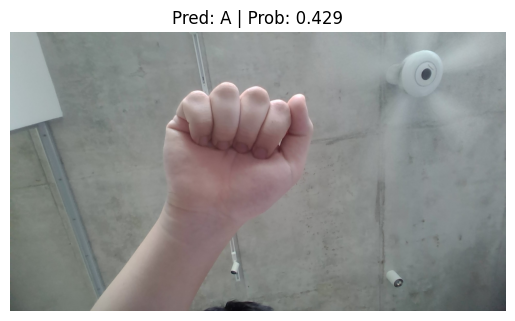

In [ ]:
model_best.eval()
with torch.inference_mode():
  y_pred = model_best(img_tensor.to(device)) # Move the input tensor to the same device as the model
  target_image_pred_probs = torch.softmax(y_pred, dim=1)

  # 9. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);